# マルコフ連鎖モンテカルロ（MCMC）法

## MCMCとベイズ統計学の関係

### 積分計算の大変さ

ベイズ統計学では事後分布を推定してEAP推定量などの推定量を得るが、その際は積分の計算が出てくる（例えばEAPのための期待値計算での積分）

微分なら演算が閉じている（例えば $d x^2 / dx = 2x$ や $d \log x/dx = 1/x$ のように初等的な演算に還元される）が、積分は閉じていないので評価のコストが高い。

例えば、$d$ 次元母数ベクトル $\boldsymbol{\theta}=\left(\theta_1, \theta_2, \cdots, \theta_d\right)$ があったとして、1番目の母数$\theta_1$のEAP推定量を求めるためには

$$
\begin{aligned}
\hat{\theta}_{1 \text { eap }}
& =\int \theta_1 f\left(\theta_1 \mid \boldsymbol{x}\right) d \theta_1\\
& =\int \theta_1 \int \cdots \int 
\underbrace{ f\left(\theta_1, \theta_2, \cdots, \theta_d \mid \boldsymbol{x}\right) }_{ f(\boldsymbol{\theta} \mid \boldsymbol{x}) }
d \theta_d d \theta_{d-1} \cdots d \theta_1 \\
\end{aligned}
$$

のように、事後分布$f(\boldsymbol{\theta} \mid \boldsymbol{x})$の$d$次元の積分を評価しなければならない。この積分は一般的に、解析的に解くことができない。

### 事後分布から乱数を発生させて解く

そこで、事後分布 $f(\theta \mid x) \propto f(x \mid \theta)\, f(\theta)$ から母数の乱数 $\theta^{(1)}, \theta^{(2)}, \dots$ を発生させて、母数の実現値を取得することにする。
母数の実現値たちが事後分布を十分に近似できていれば、その標本平均をEAPの推定値とすることができる。

ただし、このアプローチをとるにあたっては課題が2つある

**1. どうやって乱数を発生させるか？**

疑似乱数を発生させるプログラムでは、所与の分布のもとでの実現値 $f(x \mid \boldsymbol{\theta})$  を発生させるようにできており、事後分布 $f(\boldsymbol{\theta} \mid \boldsymbol{x})$ の生成のために作られては居ない

**2. 事後分布の正規化定数は評価できないことが多い**

正規化定数 $\int_{\mathbb{R}^d} f(x)\,dx$ は $d$次元の積分計算を含み、簡単には評価できない。
正規化定数が不明だと事後確率密度そのものは計算できないが、その状態でカーネルだけで事後分布をどう計算するか？という課題がある。

## マルコフ連鎖

- ある状態から、別の状態に推移する確率だけが決まっている
- 1期前だけが次の状態に影響する
- 連鎖はずっと続く（0%/100%がない）

という確率過程。

:::{card} 数式

$t$期の確率変数を$y_t$とし、確率過程を$\{y_t\}^\infty_{t=0}$と表すことにする。

マルコフ過程では、確率変数$y_t$の確率密度関数が一期前にのみ依存するため

$$
f(y_t|y_{t-1})
$$

と表される

:::


### 定常分布

各状態にたどり着く確率が変化しなくなってくる。これを**定常分布**という


任意の状態A,Bについて、Aが生じる確率$S(A)$とAからBに遷移する確率$T(B|A)$が一致すること

$$
T(B|A)S(A) = T(A|B)S(B)
$$

を**詳細つり合い条件（detailed balance condition）**という。

詳細釣り合い条件はマルコフ連鎖が定常分布に収束するための十分条件とされる。


MCMCを使う場合は，この条件を満たすように 推移確率$T(𝜃'|𝜃)$を作りたい

## メトロポリス・ヘイスティング（MH）法

:::{margin}

ベイズ統計学とは無関係の物理化学の分野でMetropolisによって1953年に提案され、1970年にHastingsが統計学向けにアルゴリズムの形式に整理してBiometrikaに投稿したのでこの名前で呼ばれる

:::

Metropolis–Hastings（MH）は、**正規化定数が分からない確率分布**からサンプルを生成するための **MCMC（Markov Chain Monte Carlo）** アルゴリズムである。

- 最も単純な方法
- だいたいうまくいかない
- 事後分布 $p(\theta \mid y)$ の **正規化定数** $Z = \int p(y \mid \theta)p(\theta)\, d\theta$ は不要で、比率 $p(\theta' \mid y) / p(\theta \mid y)$ だけ使う



基本アイデア

- 現在の状態 $\theta$ から **提案分布（proposal）** $q(\theta' \mid \theta)$ により候補 $\theta'$ を生成
- $\theta'$ を **確率的に受理 or 棄却**
- この操作を繰り返すことで、極限的に $p(\theta \mid y)$ に従うマルコフ連鎖を得る

アルゴリズムの概要：

1. 推移確率行列にまず適当な確率分布を置く
   - 正規分布がよく使われる
   - $T(\theta'|\theta)=N(\theta, \sigma)$
2. その提案分布を補正する処置を施す
   - $r N(\theta, \sigma)$
   - 提案分布からの採用率を、尤度と事前分布から計算する

$$
r=\frac{
    N\left(\theta^{\prime} \mid \theta, \sigma\right) P(\theta \mid y)
}{
    N\left(\theta \mid \theta^{\prime}, \sigma\right) P\left(\theta^{\prime} \mid y\right)
}
$$

正規分布は左右対称→$N\left(\theta^{\prime} \mid \theta, \sigma\right)$と$N\left(\theta \mid \theta^{\prime}, \sigma\right)$は一致するので約分できる

:::{admonition} Metropolis–Hastings アルゴリズム

**1. 初期化**

初期値 $\theta^{(0)}$ を適当に選ぶ。

$t = 1, \dots, T$について以下を繰り返す：

**2. 提案ステップ**

現在の状態 $\theta^{(t)}$ の提案分布 $q(\theta' \mid \theta^{(t)})$ から乱数を生成：

$$
\theta' \sim q(\theta' \mid \theta^{(t)})
$$

例：ランダムウォーク提案 $\theta' = \theta^{(t)} + \varepsilon,\quad \varepsilon \sim \mathcal{N}(0, s^2)$


**3. 受理確率の計算**

受理確率 $r(\theta^{(t)}, \theta')$ を

$$
r(\theta^{(t)}, \theta')
=
\min\left(
1,\;
\frac{
p(\theta' \mid y)\, q(\theta^{(t)} \mid \theta')
}{
p(\theta^{(t)} \mid y)\, q(\theta' \mid \theta^{(t)})
}
\right)
$$

と定義する。

※事後分布の定義 $p(\theta \mid y) \propto p(y \mid \theta)\, p(\theta)$ を代入すると

$$
r
=
\min\left(
1,\;
\frac{
p(y \mid \theta')\, p(\theta')\, q(\theta^{(t)} \mid \theta')
}{
p(y \mid \theta^{(t)})\, p(\theta^{(t)})\, q(\theta' \mid \theta^{(t)})
}
\right)
$$

ここで正規化定数は完全に相殺される。

**4. 確率$r$で受理or棄却**

一様乱数 $u \sim \mathrm{Uniform}(0,1)$ を生成し、

- $u < r$ なら **受理**： $\theta^{(t+1)} = \theta'$
- それ以外は **棄却**： $\theta^{(t+1)} = \theta^{(t)}$

:::

##### 対称提案分布の場合（重要）

もし
$$
q(\theta' \mid \theta) = q(\theta \mid \theta')
$$
（例：正規分布によるランダムウォーク）なら、

$$
\alpha
=
\min\left(
1,\;
\frac{
p(y \mid \theta')\, p(\theta')
}{
p(y \mid \theta^{(t)})\, p(\theta^{(t)})
}
\right)
$$

→ **Metropolis アルゴリズム**になる。


#### 対数空間での実装（実務上必須）

数値安定性のため、通常は対数を用いる。

**対数事後分布**

$$
\log p(\theta \mid y)
=
\log p(y \mid \theta) + \log p(\theta) + C
$$

**対数受理確率**

$$
\log \alpha
=
\log p(y \mid \theta') + \log p(\theta')
-
\left[
\log p(y \mid \theta^{(t)}) + \log p(\theta^{(t)})
\right]
$$

実装では$\log u < \log \alpha$で比較する。



#### なぜ正しい分布に収束するか

Metropolis–Hastings で作られるマルコフ連鎖は：

- **詳細釣り合い条件（detailed balance）**
$$
p(\theta \mid y)\, T(\theta \to \theta')
=
p(\theta' \mid y)\, T(\theta' \to \theta)
$$
を満たす

→ $p(\theta \mid y)$ が **定常分布**になる  
→ 長く回すとサンプルは事後分布に従う



acceptance rate = 0.279
posterior mean  = 1.624
posterior sd    = 0.140


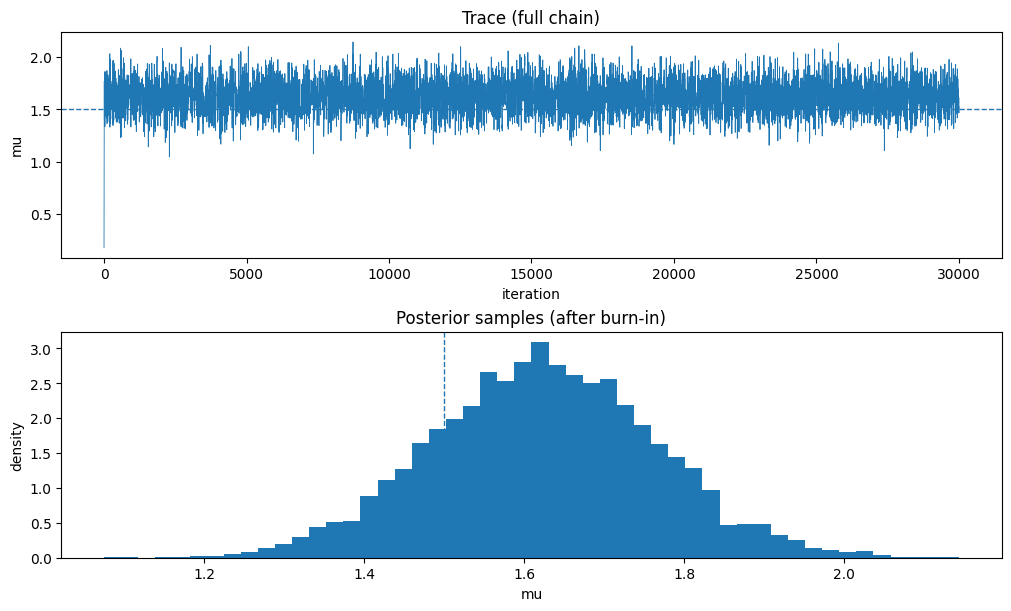

In [3]:
"""
Metropolis-Hastings
- モデル: y_i ~ Normal(mu, sigma^2), 既知sigma
- 事前:   mu ~ Normal(0, tau^2)
→ 事後 p(mu|y) を MCMC でサンプリング

ポイント:
- 正規化定数は不要（log事後の差だけ使う）
- 受理率(acceptance rate)と提案分布幅(step)で挙動が変わる
"""

import numpy as np
import matplotlib.pyplot as plt


# -----------------------------
# 1) データ生成（学習用に真値から作る）
# -----------------------------
rng = np.random.default_rng(0)
mu_true = 1.5
sigma = 1.0
n = 50
y = rng.normal(loc=mu_true, scale=sigma, size=n)

# 事前（mu ~ N(0, tau^2)）
tau = 3.0


# -----------------------------
# 2) log事後（正規化定数は捨ててOK）
#    log p(mu|y) = log p(y|mu) + log p(mu) + const
# -----------------------------
def log_posterior(mu: float, y: np.ndarray, sigma: float, tau: float) -> float:
    # log likelihood: sum_i log N(y_i | mu, sigma^2)
    # 定数項 -0.5*log(2πσ^2) は差分で消えるので省略して良い
    ll = -0.5 * np.sum(((y - mu) / sigma) ** 2)

    # log prior: log N(mu | 0, tau^2) も定数は省略して良い
    lp = -0.5 * ((mu / tau) ** 2)

    return ll + lp


# -----------------------------
# 3) Metropolis-Hastings（ランダムウォーク提案）
#    mu' = mu + Normal(0, step^2)
# -----------------------------
def metropolis_hastings(
    y: np.ndarray,
    sigma: float,
    tau: float,
    n_samples: int = 20_000,
    burn_in: int = 2_000,
    step: float = 0.5,
    init: float = 0.0,
    seed: int = 123,
):
    rng = np.random.default_rng(seed)

    samples = np.empty(n_samples, dtype=float)

    mu = float(init)
    logp = log_posterior(mu, y, sigma, tau)

    accepted = 0

    for t in range(n_samples):
        # 提案
        mu_prop = mu + rng.normal(0.0, step)
        logp_prop = log_posterior(mu_prop, y, sigma, tau)

        # 受理確率: alpha = min(1, exp(logp_prop - logp))
        # 数値安定のため、log空間で比較する
        log_alpha = logp_prop - logp

        if np.log(rng.random()) < log_alpha:
            mu = mu_prop
            logp = logp_prop
            accepted += 1

        samples[t] = mu

    acc_rate = accepted / n_samples

    # burn-in を捨てて返す
    post = samples[burn_in:]
    return post, samples, acc_rate


# -----------------------------
# 4) 実行
# -----------------------------
post, trace, acc_rate = metropolis_hastings(
    y=y,
    sigma=sigma,
    tau=tau,
    n_samples=30_000,
    burn_in=3_000,
    step=0.6,   # ←ここを変えると挙動が変わる（重要）
    init=0.0,
    seed=42,
)

print(f"acceptance rate = {acc_rate:.3f}")
print(f"posterior mean  = {post.mean():.3f}")
print(f"posterior sd    = {post.std(ddof=1):.3f}")


# -----------------------------
# 5) 可視化（トレース & ヒストグラム）
# -----------------------------
fig, ax = plt.subplots(2, 1, figsize=(10, 6), constrained_layout=True)

ax[0].plot(trace, linewidth=0.6)
ax[0].axhline(mu_true, linestyle="--", linewidth=1.0)
ax[0].set_title("Trace (full chain)")
ax[0].set_xlabel("iteration")
ax[0].set_ylabel("mu")

ax[1].hist(post, bins=50, density=True)
ax[1].axvline(mu_true, linestyle="--", linewidth=1.0)
ax[1].set_title("Posterior samples (after burn-in)")
ax[1].set_xlabel("mu")
ax[1].set_ylabel("density")

plt.show()



## ハミルトニアン・モンテカルロ（HMC）法

ハミルトニアン方程式を使って推移確率行列を構成
• 勾配情報をつかい、運動エネルギーと位置を更新していく

### NUTS

- not u-turn
- HMCの改良版
  - 更新頻度とハイパーパラメータを自動調整
  - Stan, NumPyro, PyMCなど多くのパッケージがNUTSを利用